#Mount Google Drive, Define **Path**



In [1]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Define Path
path_records = '/content/drive/MyDrive/Github/Article/records'
# Set Path
path_wd = '/content/drive/MyDrive/Github/Article'
path_font = '/content/drive/MyDrive/Github/Article/fonts/STHUPO.TTF'
path_img = '/content/drive/MyDrive/Github/Article/img'
path_reg = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm'
path_zgdypw = '/content/drive/MyDrive/Github/Content/sources/zgdypw'

os.chdir(path_wd)

# Install requirements and restart

In [3]:
%%capture
!pip install pandas==1.3.2
!pip install transformers
# Install Requirements
!pip install -r /content/drive/MyDrive/Github/Content/sources/ChinaFilm/requirements.txt
!apt update
#!apt-get update # to update ubuntu to correctly run apt install
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
!pip install selenium
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

# Import Libraries

In [3]:
# Import External Libs
import pandas as pd
import numpy as np
import datetime as dt
import re
import gc
import random

from IPython.display import display, HTML
import torch
from transformers import AdamW, BartForConditionalGeneration

from selenium import webdriver

import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank

import matplotlib as mp
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.font_manager as fm

path_fonts = '/content/drive/MyDrive/Github/Article/fonts'
fontprop = fm.FontProperties(fname=path_fonts, size= 15)

font_dirs = [path_fonts, ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
#font_list = fm.createFontList(font_files)
for font in font_files:
  fm.fontManager.addfont(font)

plt.rcParams['figure.figsize'] = [15, 9]
mp.rcParams['font.family'] = ['Microsoft YaHei']

%matplotlib inline

In [4]:
# Load Libraries Local
path_Content = '/content/drive/MyDrive/Github/Content'
os.chdir(path_Content)

#%load_ext autoreload
%reload_ext autoreload

# ZGDYPW
os.chdir(path_Content + '/sources/zgdypw')
from zgdypw import ZGDYPW
zgd = ZGDYPW()

# Chromedriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome('chromedriver',options=chrome_options)

# ChinaFilm
os.chdir(path_Content + '/sources/ChinaFilm')
from Record_Registration import Registration
dy_reg = Registration(driver)

os.chdir(path_wd)
from generate import utils as ut

/content/drive/MyDrive/Github/Article/generate/utils.py:21: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = fm.createFontList(font_files)
Installing paddle-tiny, please wait a minute......
Paddle enabled successfully......


#Load Release and Registration Records

## Update Sources to latest

In [5]:
# Update ChinaFilm Release Records
path_reg = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm'
os.chdir(path_reg)
!python Update_Release.py

31 records saved to records/links_of_publications_releases.json.
Traceback (most recent call last):
  File "Update_Release.py", line 14, in <module>
    contents_of_releases = dy_rel.contents_of_releases(links_of_publications, savefile=True)
  File "/content/drive/MyDrive/Github/Content/sources/ChinaFilm/Record_Release.py", line 171, in contents_of_releases
    with urlopen(req) as x:
  File "/usr/lib/python3.7/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/usr/lib/python3.7/urllib/request.py", line 525, in open
    response = self._open(req, data)
  File "/usr/lib/python3.7/urllib/request.py", line 543, in _open
    '_open', req)
  File "/usr/lib/python3.7/urllib/request.py", line 503, in _call_chain
    result = func(*args)
  File "/usr/lib/python3.7/urllib/request.py", line 1378, in http_open
    return self.do_open(http.client.HTTPConnection, req)
  File "/usr/lib/python3.7/urllib/request.py", line 1353, in do_open
    r = h.getresponse

In [ ]:
# Update ChinaFilm Reg Records
path_reg = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm'
os.chdir(path_reg)
!python Update_Registration.py

In [7]:
# Update zgdypw Release Records
path_rel = '/content/drive/MyDrive/Github/Content/sources/zgdypw'
os.chdir(path_rel)
!python update.py

file saved to: contents_of_releases.json with a total of  218  records.


## Import Records

In [ ]:
# Import zgdypow Releases
fp = path_rel + '/records/contents_of_releases.json'
df_rel = pd.read_json(fp)
df_rel = df_rel.sort_values('pubdate', ascending=False)
str_pubdate_latest = df_rel['pubdate'].iloc[0]

df_rel_curr = df_rel[df_rel['pubdate'] == str_pubdate_latest]
df_rel_curr.loc[:, 'pubdate'] = pd.to_datetime(df_rel_curr['pubdate'].apply(lambda x: x.rstrip('（重映）')))
df_rel_curr.loc[:, '上映日期'] = pd.to_datetime(df_rel_curr['上映日期'].apply(lambda x: x.rstrip('（重映）')))

df_rel_curr = df_rel_curr.sort_values('上映日期')
dt_pubdate_latest = df_rel_curr['pubdate'].iloc[0]

#del df_rel
gc.collect()

In [165]:
dt_pubdate_latest

Timestamp('2021-12-03 00:00:00')

In [166]:
# Import ChinaFilm Registrations
fp = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_registrations.json'
df_reg = pd.read_json(fp, orient='record')
df_reg['匹配片名'] = df_reg['片名']

# Import ChinaFilm Releases
fp = '/content/drive/MyDrive/Github/Content/sources/ChinaFilm/records/contents_of_releases.json'
df_cf_releases = pd.read_json(fp)

In [12]:
df_rel_curr.columns

Index(['电影名称', 'pubtitle', 'pubdate', 'publink', '上映日期', '导演', '国别/地区',
       'img_remote', '主演'],
      dtype='object')

In [14]:
df_reg.columns

Index(['电影类别', '备案立项号', '片名', '备案单位', '编剧', '备案结果', '备案地', '梗概', '公示日期',
       '公示批次名称', '备案详细页链接', '公示批次链接', '匹配片名'],
      dtype='object')

In [13]:
df_cf_releases.columns

Index(['序号', '电影类别', '编码', '公映证号', '片名', '第一出品单位', '公示批次链接', '公示名称', '公示日期'], dtype='object')

#Interactively Find matches

## Match and Merge REL

In [167]:
# Match df_rel_curr to df_cf_releases
df_rel_curr['片名_cfReleases'] = df_rel_curr['电影名称']
df_matched_rel = df_cf_releases[df_cf_releases['片名'].isin(df_rel_curr['电影名称'])]
df_matched_rel['电影名称'] = df_matched_rel['片名'].copy()
idx_no_match = df_rel_curr.loc[~df_rel_curr['电影名称'].isin(df_matched_rel['片名'])].index
df_rel_curr.loc[df_rel_curr.index.isin(idx_no_match), '片名_cfReleases'] = None
#df_rel_curr.loc[df_rel_curr['匹配片名'].isna(), :]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [16]:
df_rel_curr.columns

Index(['电影名称', 'pubtitle', 'pubdate', 'publink', '上映日期', '导演', '国别/地区',
       'img_remote', '主演', '片名_cfReleases'],
      dtype='object')

In [ ]:
HTML(df_rel_curr.to_html())

In [ ]:
df_rel_curr.loc[df_rel_curr['片名_cfReleases'].isna(), :]

In [169]:
# RUN ONLY ONCE
found_cfReleases = [None, None, None, None, None, '孤山魅影', None,
       '屋内有人']
df_rel_curr.loc[(df_rel_curr['片名_cfReleases'].isna()) & 
                (df_rel_curr['国别/地区'] == '中国'), '片名_cfReleases'] = found_cfReleases

df_matched_rel = df_cf_releases[df_cf_releases['片名'].isin(df_rel_curr['片名_cfReleases'])]
df_matched_rel.rename(columns={'片名':'片名_cfReleases'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [170]:
df_rel_curr.loc[(df_rel_curr['片名_cfReleases'].isna()) & 
                (df_rel_curr['国别/地区'] == '中国'), '电影名称'].to_numpy()

array(['我们是第⼀书记', '半个⽉亮爬上来', '笨鸟⼤冒险', '曾经相爱的我们', '雄狮少年', '魔法精灵'],
      dtype=object)

In [ ]:
# Search Release Records
df_cf_releases[df_cf_releases['片名'].str.contains('幺幺')]

In [ ]:
df_matched_rel.columns

Index(['序号', '电影类别', '编码', '公映证号', '片名_cfReleases', '第一出品单位', '公示批次链接', '公示名称',
       '公示日期'],
      dtype='object')

In [171]:
# Merge
df_rel_curr = df_rel_curr.merge(df_matched_rel, on='片名_cfReleases', how='left')

门锁', '黄⾦⼟', '七⽉的舞步', '误杀2', '让这⾸歌作证'

In [ ]:
df_cf_releases['片名'].to_numpy()[0:100]

## Match and Merge Rel Reg

In [ ]:
# Match df_rel_curr to df_reg
df_rel_curr['片名_cfReg'] = df_rel_curr['电影名称']
df_matched = \
  df_reg[df_reg['片名'].isin(df_rel_curr['片名_cfReg'].to_numpy())]
idx_no_match = df_rel_curr.loc[~df_rel_curr['片名_cfReg'].isin(
    df_matched['片名'].to_numpy())].index
df_rel_curr.loc[df_rel_curr.index.isin(idx_no_match), '片名_cfReg'] = None
df_rel_curr.loc[(df_rel_curr['片名_cfReg'].isna()) & 
    (df_rel_curr['国别/地区'] == '中国'), 
    ['电影名称', 'pubtitle', 'pubdate', 'publink', '上映日期', '导演', '主演', '第一出品单位']]

In [173]:
df_rel_curr.loc[(df_rel_curr['片名_cfReg'].isna()) & 
    (df_rel_curr['国别/地区'] == '中国'), '电影名称'].to_numpy()

array(['我们是第⼀书记', '半个⽉亮爬上来', '笨鸟⼤冒险', '曾经相爱的我们', '雄狮少年', '恐婚：逃跑计划',
       '孤⼭魅影', '屋内有⼈ '], dtype=object)

In [174]:
# assign manually found titles to df_curr_releases
found_reg = ['我们是第一书记', '掀起你的盖头来', '笨鸟大冒险', '北京晚九朝五', '雄狮少年的天空', '“桃”之幺幺',
       '孤山魅影', '屋内有人']
df_rel_curr.loc[(df_rel_curr['片名_cfReg'].isna()) & 
    (df_rel_curr['国别/地区'] == '中国'), '片名_cfReg'] = found_reg


# 掀起你的盖头来 24911

In [175]:
# Merge
df_reg['片名_cfReg'] = df_reg['片名']
df_matched = df_reg.loc[df_reg['片名_cfReg'].isin(df_rel_curr['片名_cfReg'].to_numpy()),
                        ['片名_cfReg', '编剧', '梗概', '公示日期', 
                         '备案单位', '备案结果', '备案立项号']
                       ]
df_matched.rename(columns={'公示日期':'备案公示日期'}, inplace=True)
df = df_rel_curr.merge(df_matched, on='片名_cfReg', how='left')

In [176]:
df['备案公示日期'] = df['备案公示日期'].apply(
    lambda x: pd.to_datetime(x, infer_datetime_format=True))
df['备案至今'] = dt_pubdate_latest - df['备案公示日期']

##Remove Duplicates (if any)

In [ ]:
HTML(df.to_html())

In [ ]:
# RUN ONCE
idx_to_remove = []
df = df[~df.index.isin(idx_to_remove)].reset_index(drop=True)

In [215]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12 entries, 0 to 11
Data columns (total 32 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   电影名称           12 non-null     object         
 1   pubtitle       12 non-null     object         
 2   pubdate        12 non-null     datetime64[ns] 
 3   publink        12 non-null     object         
 4   上映日期           12 non-null     datetime64[ns] 
 5   导演             12 non-null     object         
 6   国别/地区          12 non-null     object         
 7   img_remote     12 non-null     object         
 8   主演             11 non-null     object         
 9   片名_cfReleases  6 non-null      object         
 10  序号             6 non-null      float64        
 11  电影类别           6 non-null      object         
 12  编码             6 non-null      object         
 13  公映证号           6 non-null      object         
 14  第一出品单位         6 non-null      object         
 15  公示批次链接  

## Search for foreign film synopsis

In [40]:
# Load Libraries Local
path_Baike = '/content/drive/MyDrive/Github/Content/sources/baike'
os.chdir(path_Baike)

#%load_ext autoreload
%reload_ext autoreload
from Baike import Baike
baike = Baike()

In [55]:
baike.search_for_content('曾经相爱的我们')

'《曾经相爱的我们》是由张小磊执导，陈柏霖、郭采洁领衔主演的爱情电影。该片讲述了以Alan和梦捷为代表的青年男女，在大城市中奋斗、相爱的故事。该片于2021年12月10日上映。'

In [ ]:
df.loc[df['电影名称'] == '入殓师', '梗概'] = synop_passing
df.loc[df['电影名称'] == '007：无暇赴死', '梗概'] = synpo_007

## SEARCH TOOLS

In [ ]:
HTML(df_reg.loc[df_reg['备案单位'].fillna('').str.contains('广州易动'), 
           ['片名', '备案立项号', '备案单位', '编剧', '梗概', '公示日期']].to_html())

In [71]:
df_reg.loc[df_reg['片名'].fillna('').str.contains('孤山魅影')]#.loc[6502,'梗概']

,电影类别,备案立项号,片名,备案单位,编剧,备案结果,备案地,梗概,公示日期,公示批次名称,备案详细页链接,公示批次链接,匹配片名
8949,故事片,影剧备字[2018]第2491号,孤山魅影,杭州安迪文化传播有限公司,黎海涛,修改后同意拍摄,浙江省,一个有着心理创伤的青年雷去孤山调查一件有关他爷爷的悬案，却被卷进两个女人的复仇漩涡，他试图在...,2018-10-30,国家电影局关于2018年10月（上旬、中旬）全国电影剧本（梗概） 备案、立项公示的通知-电...,http://www.chinafilm.gov.cn/chinafilm/utils/se...,http://www.chinafilm.gov.cn/chinafilm/contents...,孤山魅影


In [64]:
df_reg.loc[df_reg['编剧'].fillna('').str.contains('里则林'), 
           ['片名', '备案单位', '编剧', '梗概', '备案立项号']] 

,片名,备案单位,编剧,梗概,备案立项号


In [56]:
HTML(df_reg.loc[df_reg['梗概'].fillna('').str.contains('梦洁jieba'), 
           ['片名', '备案单位', '编剧', '梗概', '备案立项号']].to_html())

,片名,备案单位,编剧,梗概,备案立项号


In [72]:
HTML(df_reg.loc[df_reg['片名'].fillna('').str.contains('屋内有人'), 
           ['片名', '备案单位', '编剧', '梗概', '备案立项号']].to_html())

,片名,备案单位,编剧,梗概,备案立项号
6979,屋内有人,浙江东阳震之影视文化有限公司,边缘,女演员安然深夜回家躺在床上之后，发现了一件极其恐惧的事实——床下藏着一黑衣人。黑衣人是个窃贼，看到美丽的安然后又起了色心。一个想营救自己，一个想侵犯对方，安然和黑衣人开始了殊死较量。,影剧备字[2018]第8441号


In [ ]:
df_reg.loc[df_reg['电影类别'].fillna('').str.contains('纪录'), 
           ['片名', '备案单位', '编剧', '梗概', '备案立项号']] 

In [ ]:
df.shape

(16, 16)

In [ ]:
df['电影名称']

#Run Models for prediction

## Predict Genre

In [178]:
# Define Labels
label2id_genre= {'传奇': 0, '传记': 1, '其它': 2, '军旅': 3, '农村': 4, '宫廷': 5,  
                  '武打': 6, '涉案': 7, '神话': 8, '科幻': 9, '都市': 10, '青少': 11,
                  '革命': 12}
id2label_genre = {}
for k, v in label2id_genre.items(): id2label_genre[v] = k

In [179]:
%%capture
# Genre Classifier
N_LABELS = len(id2label_genre)
ID2LABEL = id2label_genre
LABEL2ID = label2id_genre

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAgenre'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [180]:
batch_size = 8
i = 0
ls = df['梗概'].fillna('').tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df['类型'] = test_predictions
df['类型'] = df['类型'].apply(lambda x: id2label_genre[x])

## Predict Time

In [181]:
# Define Labels
label2id_time = {'古代': 0, '当代': 1, '现代': 2, '近代': 3}
id2label_time = {}
for k, v in label2id_time.items(): id2label_time[v] = k

In [182]:
%%capture
# Time Classifier

N_LABELS = len(id2label_time)
ID2LABEL = id2label_time
LABEL2ID = label2id_time

from transformers import BertTokenizer, BertForSequenceClassification
import torch
############
model_name = '/content/drive/MyDrive/Github/Content/tools/models/chinese-bert-wwm-classification-NRTAtime'
############
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(
  model_name,
  num_labels=N_LABELS,
  problem_type="multi_label_classification",
  id2label=ID2LABEL,
  label2id=LABEL2ID,  
).to(device)
model.eval() # set model to eval mode for faster prediction

In [183]:
batch_size = 8
i = 0
ls = df['梗概'].fillna('').tolist()
softmax = torch.nn.Softmax(dim=-1)
L = df.shape[0]
test_predictions = []

while i < L:
  batch_test = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  batch_test.to(device)
  batch_outputs = model(**batch_test)
  batch_logtis = batch_outputs.logits
  batch_softmax = softmax(batch_logtis)
  batch_results = torch.argmax(batch_softmax, dim=1).cpu().numpy()
  test_predictions.extend(list(batch_results))
  i += batch_size

df['年代'] = test_predictions
df['年代'] = df['年代'].apply(lambda x: id2label_time[x])

## Predict Title

In [184]:
%%capture
from transformers import BertTokenizer, BartForConditionalGeneration

# assign device
if torch.cuda.device_count() > 0:
  device = 'cuda:' + str(torch.cuda.current_device())
else:
  device = 'cpu'

# Instantiate tokenizer and model
checkpoint = "/content/drive/MyDrive/Github/Content/tools/models/PredTitle-10000"

  
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BartForConditionalGeneration.from_pretrained(checkpoint,
                                            gradient_checkpointing=True, 
                                            use_cache=False)
model.to(device)
model.eval()

batch_size = 8
i = 0
ls = df['梗概'].fillna('').tolist()
L = df['梗概'].shape[0]
test_predictions = []

while i < L:
  inputs = tokenizer(ls[i:i+batch_size],
                           padding=True,
                           max_length=512, 
                           truncation=True, 
                           return_tensors='pt')
  inputs.to(device)
  summary_ids = model.generate(input_ids=inputs['input_ids'],
                             num_beams=4,
                             min_length=0,
                             max_length=32
                             )
  
  ret = [tokenizer.decode(g, 
                         skip_specical_tokens=True, 
                         clean_up_tokenization_spaces=True) for g in summary_ids]
  test_predictions.extend(ret)
  i += batch_size

df['预测片名'] = test_predictions

def remove_specials(x):
  x = re.sub(' ', '', x)
  x = re.sub('\[CLS\]', '', x)
  x = re.sub('\[PAD\]', '', x)
  x = re.sub('\[SEP\]', '', x)
  return x

df['预测片名'] = df['预测片名'].apply(remove_specials)

## Extract top keywords

In [185]:
import jieba.analyse
tfidf = jieba.analyse.extract_tags
textrank = jieba.analyse.textrank

df['kw'] = df['梗概'].fillna('').apply(textrank, topK=10)

## Identify Main Characters

In [186]:
import jieba
import jieba.posseg as pseg
jieba.enable_paddle() #启动paddle模式。 0.40版之后开始支持，早期版本不支持

Paddle enabled successfully......


In [187]:
# 识别主要角色
def find_PER(x: pd.Series):
  words = pseg.cut(x, use_paddle=True)
  ls_PER = []
  for word, flag in words:
    if flag == 'PER':
      word = word.strip('[\s,，。、“”？；]')
      ls_PER.append(word)
  ls_PER = list(set(ls_PER))

  ls_PER1 = ls_PER.copy()
  ls_PER = []
  while ls_PER1:
    PER =  ls_PER1.pop(0)
    ls_tmp = re.split('[\s,，。、“”？；]', PER)
    ls_PER.extend(ls_tmp)

  ls_PER = list(set(ls_PER)) 
  ls_PER = [PER for PER in ls_PER if len(PER) > 1]
  ls_PER_sorted = sorted(ls_PER, reverse=False, key=lambda x: len(x))

  ans = []
  while ls_PER_sorted:
    PER = ls_PER_sorted.pop(0)
    i = 0
    while i < len(ls_PER_sorted):
      if re.search(PER, ls_PER_sorted[i]):
        ls_PER_sorted.pop(i)
        ans.append(PER)
      i += 1
    if PER not in ans:
      ans.append(PER)

  return ans

In [188]:
df['主要角色'] = df['梗概'].fillna('').apply(find_PER)

In [189]:
df[['主要角色', '梗概']]

,主要角色,梗概
0,[],影片真实记录了全国各地扶贫驻村第一书记搞产业、兴教育、抗台风、保丰收等事迹，讲述了他们为老百...
1,"[王洛宾, 拉壮丁一路西行]",这是一部有关西部歌王的传奇故事的音乐故事片:王洛宾被拉壮丁一路西行，坎坷的经历，浪漫的爱情，...
2,[],一只小鸻鹬因为没有学会飞翔，而被迁徙的鸟群落下，它要一个人面对寒冷的冬天以及捕食者的威胁，最...
3,[常遇春],电影《你最珍贵》描写了当代大学生江蓝、程浩、常遇春为了实现自己的理想，摈弃物欲的诱惑，到艰苦...
4,"[安琪, 胡董]","向前、安琪、Kevin、冰冰、Simon、胡董等人来自各地,白天和夜晚/梦想与现实,在追逐爱..."
5,"[阿娟, 阿狗]",本片讲诉了留守少年阿娟和好友阿猫、阿狗在退役狮王咸鱼强的培训下参加舞狮比赛，经过重重磨砺，从...
6,"[小桃, 叶芷涵]",恐婚男护士范小桃和女友叶芷涵遭双方家长逼婚，无奈踏上回老家领证之旅。途中小桃伙同死党浩子设计...
7,"[孙三, 李四, 钱二, 赵晓晓, 赵芸芸]",钱二、孙三、李四是充满正义感，亲密无间好兄弟。在对付恶人的过程中却不慎落入了女搭档赵芸芸的圈...
8,[],该剧以铁建等两代中铁职工在某山区艰苦、恶劣复杂环境下，不畏艰险，克服重重困难，终于凭借科技创...
9,[悬案],一个有着心理创伤的青年雷去孤山调查一件有关他爷爷的悬案，却被卷进两个女人的复仇漩涡，他试图在...


## adjust genre

In [190]:
df.columns

Index(['电影名称', 'pubtitle', 'pubdate', 'publink', '上映日期', '导演', '国别/地区',
       'img_remote', '主演', '片名_cfReleases', '序号', '电影类别', '编码', '公映证号',
       '第一出品单位', '公示批次链接', '公示名称', '公示日期', '片名_cfReg', '编剧', '梗概', '备案公示日期',
       '备案单位', '备案结果', '备案立项号', '备案至今', '类型', '年代', '预测片名', 'kw', '主要角色'],
      dtype='object')

In [194]:
df['修正类型'] = df['类型'].copy()
df['类型'].to_numpy()

array(['都市', '其它', '其它', '都市', '都市', '都市', '都市', '都市', '其它', '传奇', '科幻',
       '都市'], dtype=object)

In [195]:
adjusted = ['农村', '传记', '动物', '剧情', '爱情', '剧情', '爱情', '剧情', '职业', '传奇', '科幻',
       '惊悚']

df['修正类型'] = adjusted

In [ ]:
HTML(df[['电影名称', '类型', '修正类型', '梗概']].to_html())

## Save Records Curr Issue

In [134]:
# Save records for current release issue
df.to_pickle(path_records + '/df_releases_zgdypw_{}.pkl'.format(str_pubdate_latest))

In [ ]:
#df = pd.read_pickle(path_records + '/df_releases_{}.pkl'.format(pubdate_latest))

In [ ]:
HTML(df.to_html())

In [116]:
# Download picture
import urllib.request

for img in df['img_remote'].to_numpy():
  fp_local = path_zgdypw + '/img/' + img.split('/')[-1]
  urllib.request.urlretrieve(img, fp_local)

# View Table


In [216]:
"""
# 出品单位变更
tmp = df[['备案单位','第一出品单位']].fillna('').apply(
    lambda x: re.search(x['第一出品单位'], x['备案单位']), axis=1).to_frame()
idx_co_change = tmp[tmp[0].isna()].index
df['公司变更'] = 0
df.loc[idx_co_change, '公司变更'] = 1

# 出品单位变更
df_view.loc[df_view['公司变更'] == 0, '备案单位'] = ''
df_view.rename(columns={'备案单位':'原备案单位'}, inplace=True)
df_view.drop('公司变更', axis=1, inplace=True)
""" 
# 改名
df_view = df.copy()
df_view.loc[df_view['电影名称'] == df_view['片名_cfReleases'], '片名_cfReleases'] = ''
df_view.rename(columns={'片名_cfReleases':'备案名'}, inplace=True)



# 备案修改
df_view.loc[df_view['备案结果'].fillna('').str.contains('修改'),'备案结果'] = '是'
df_view.loc[df_view['备案结果'].fillna('').str.contains('同意'),'备案结果'] = ''
df_view.rename(columns={'备案结果':'是否修改'}, inplace=True)

# 备案至今
df_view['备案至今'] = round((df_view['备案至今'].dt.days + 60) / 365, 1)
#df_view.sort_values(by='备案至今', ascending=False, inplace=True)
#df_view['备案至今'] = df_view['备案至今'].apply(lambda x: '> ' + str(x) + ' 年')

# 公映许可至今

# 上映日期(月)
df_view['公示日期'] = pd.to_datetime(df_view['公示日期'])
df_view['距离公映许可'] = (12*(df_view['上映日期'].dt.year-df_view['公示日期'].dt.year) 
  + (df_view['上映日期'].dt.month - df_view['公示日期'].dt.month))

In [217]:
# soft df_view by years since registration in descending order
df_view = df_view.sort_values('备案至今', ascending=False)

In [198]:
df_view.columns

Index(['电影名称', 'pubtitle', 'pubdate', 'publink', '上映日期', '导演', '国别/地区',
       'img_remote', '主演', '备案名', '序号', '电影类别', '编码', '公映证号', '第一出品单位',
       '公示批次链接', '公示名称', '公示日期', '片名_cfReg', '编剧', '梗概', '备案公示日期', '备案单位',
       '是否修改', '备案立项号', '备案至今', '类型', '年代', '预测片名', 'kw', '主要角色', '修正类型',
       '距离公映许可'],
      dtype='object')

In [ ]:
HTML(df_view.to_html())

# [6] Generate WordCloud

In [200]:
from IPython.display import Image as Img
from PIL import Image as pil

path_posters = '/content/drive/MyDrive/Github/Article/img/posters'
path_icon = '/content/drive/MyDrive/Github/Article/img/genre_icon'

#df_label2img.to_json(path_records + '/df_label2img.json')
df_label2img = pd.read_json(path_wd + '/records/df_label2img.json')

In [199]:
df['修正类型'].unique()

array(['农村', '传记', '动物', '剧情', '爱情', '职业', '传奇', '科幻', '惊悚'], dtype=object)

In [ ]:
df_label2img.loc[19] = ['科幻', 'octopus-4257636_1920.png']

In [246]:
df_label2img.to_json(path_records + '/df_label2img.json')

In [ ]:
id2label_time = {0: '古代', 1: '当代', 2: '现代', 3: '近代'}

id2label_genre = {0: '传奇', 1: '传记', 2: '其它', 3: '军旅', 4: '农村',
                  5: '宫廷', 6: '武打',  7: '涉案',   8: '神话',  9: '科幻',
                  10: '都市',  11: '青少',  12: '革命'
                 }
d_img_labels = {}
for t in id2label_time.values():
  for g in id2label_genre.values():
    d_img_labels[(t, g)] = None
d_img_labels.keys()

dict_keys([('古代', '传奇'), ('古代', '传记'), ('古代', '其它'), ('古代', '军旅'), ('古代', '农村'), ('古代', '宫廷'), ('古代', '武打'), ('古代', '涉案'), ('古代', '神话'), ('古代', '科幻'), ('古代', '都市'), ('古代', '青少'), ('古代', '革命'), ('当代', '传奇'), ('当代', '传记'), ('当代', '其它'), ('当代', '军旅'), ('当代', '农村'), ('当代', '宫廷'), ('当代', '武打'), ('当代', '涉案'), ('当代', '神话'), ('当代', '科幻'), ('当代', '都市'), ('当代', '青少'), ('当代', '革命'), ('现代', '传奇'), ('现代', '传记'), ('现代', '其它'), ('现代', '军旅'), ('现代', '农村'), ('现代', '宫廷'), ('现代', '武打'), ('现代', '涉案'), ('现代', '神话'), ('现代', '科幻'), ('现代', '都市'), ('现代', '青少'), ('现代', '革命'), ('近代', '传奇'), ('近代', '传记'), ('近代', '其它'), ('近代', '军旅'), ('近代', '农村'), ('近代', '宫廷'), ('近代', '武打'), ('近代', '涉案'), ('近代', '神话'), ('近代', '科幻'), ('近代', '都市'), ('近代', '青少'), ('近代', '革命')])

In [ ]:
from IPython.display import Image as Img
from PIL import Image as pil

path_posters = '/content/drive/MyDrive/Github/Article/img/posters'
path_icon = '/content/drive/MyDrive/Github/Article/img/genre_icon'

#df_label2image.to_json(path_records + '/df_label2image.json')
df_label2image = pd.read_json(path_records + '/df_label2image.json')

for i, row in df_label2img.iterrows():
  image = pil.open(path_icon + '/' + row['fn'])
  #image.thumbnail([300, sys.maxsize], pil.ANTIALIAS)
  #image.save(path_posters + '/' + row['img_poster'], format='png')
  display(Img(path_icon + '/' + row['fn'], width=300))

In [214]:
df_view

,电影名称,pubtitle,pubdate,publink,上映日期,导演,国别/地区,img_remote,主演,备案名,序号,电影类别,编码,公映证号,第一出品单位,公示批次链接,公示名称,公示日期,片名_cfReg,编剧,梗概,备案公示日期,备案单位,是否修改,备案立项号,备案至今,类型,年代,预测片名,kw,主要角色,修正类型,距离公映许可
4,曾经相爱的我们,新片上映预报,2021-12-03,https://www.zgdypw.cn/sc/scxx/202112/03/t20211...,2021-12-10,张⼩磊,中国,https://www.zgdypw.cn/sc/scxx/202112/03/W02021...,陈柏霖、郭采洁,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,北京晚九朝五,张立嘉（曾用名张立军）,"向前、安琪、Kevin、冰冰、Simon、胡董等人来自各地,白天和夜晚/梦想与现实,在追逐爱...",2012-09-19,北京众合动力影视文化传播有限公司,,影剧备字[2012]第527号,9.4,都市,当代,北京之恋,"[现实, 事业, 追逐, 爱情, 能否, 北京, 繁华都市, 困境, 陷入, 实现]","[安琪, 胡董]",爱情,NaN
7,不欺不遇,新片上映预报,2021-12-03,https://www.zgdypw.cn/sc/scxx/202112/03/t20211...,2021-12-17,⾦光利、王庐璐,中国,https://www.zgdypw.cn/sc/scxx/202112/03/W02021...,张学恒、张维威、肖旭,,18.0,国产故事片,1100682021,67,浙江天映影视传媒有限公司,http://www.chinafilm.gov.cn/chinafilm/contents...,2021年电影公映许可证发放公示（国产故事片第四批）,2021-05-12,不欺不遇,王庐璐,钱二、孙三、李四是充满正义感，亲密无间好兄弟。在对付恶人的过程中却不慎落入了女搭档赵芸芸的圈...,2017-09-28,浙江天映影视传媒有限公司,,影剧备字[2017]第4806号,4.3,都市,当代,花季女儿,"[怀有, 情义, 做出, 兄弟, 过程, 恶人, 对付, 搭档, 身孕, 女儿]","[孙三, 李四, 钱二, 赵晓晓, 赵芸芸]",剧情,7.0
9,孤⼭魅影,新片上映预报,2021-12-03,https://www.zgdypw.cn/sc/scxx/202112/03/t20211...,2021-12-24,黎海涛,中国,https://www.zgdypw.cn/sc/scxx/202112/03/W02021...,赵晨冬、林川⼈、褚楚,孤山魅影,56.0,国产故事片,1106092020,524,杭州安迪文化传播有限公司,http://www.chinafilm.gov.cn/chinafilm/contents...,2021年电影公映许可证发放公示（国产故事片第四批）,2021-05-12,孤山魅影,黎海涛,一个有着心理创伤的青年雷去孤山调查一件有关他爷爷的悬案，却被卷进两个女人的复仇漩涡，他试图在...,2018-10-30,杭州安迪文化传播有限公司,是,影剧备字[2018]第2491号,3.3,传奇,当代,孤山之恋,"[复仇, 灵魂, 爷爷, 有关, 做出, 迷失, 悬案, 有着, 心理, 创伤]",[悬案],传奇,7.0
6,恐婚：逃跑计划,新片上映预报,2021-12-03,https://www.zgdypw.cn/sc/scxx/202112/03/t20211...,2021-12-17,刘涛滔,中国,https://www.zgdypw.cn/sc/scxx/202112/03/W02021...,黄才伦,,41.0,国产故事片,1109142019,827,长春长影影视传媒有限公司,http://www.chinafilm.gov.cn/chinafilm/contents...,2020年电影公映许可证发放公示（国产故事片第四批）,2020-11-11,“桃”之幺幺,刘涛（刘涛滔）,恐婚男护士范小桃和女友叶芷涵遭双方家长逼婚，无奈踏上回老家领证之旅。途中小桃伙同死党浩子设计...,2018-12-17,森东润播文化传媒（北京）有限公司,是,影剧备字[2018]第1827号,3.1,都市,当代,恐婚男护士,"[领证, 女友, 恐婚, 事件, 设计, 浩子, 逼婚, 踏上, 家长, 战胜]","[小桃, 叶芷涵]",爱情,13.0
2,笨鸟⼤冒险,新片上映预报,2021-12-03,https://www.zgdypw.cn/sc/scxx/202112/03/t20211...,2021-12-04,袁翙鹏,中国,https://www.zgdypw.cn/sc/scxx/202112/03/W02021...,李姗姗、巩⼤⽅、汤⽔⾬,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,笨鸟大冒险,张琦,一只小鸻鹬因为没有学会飞翔，而被迁徙的鸟群落下，它要一个人面对寒冷的冬天以及捕食者的威胁，最...,2019-07-04,佛山炫彩社影视传媒有限公司,,影动备字[2019]第102号,2.6,其它,当代,小[UNK][UNK]的春天,"[避难, 威胁, 朋友, 找到, 帮助, 没有, 学会, 捕食者, 迎来]",[],动物,NaN
11,屋内有⼈,新片上映预报,2021-12-03,https://www.zgdypw.cn/sc/scxx/202112/03/t20211...,2022-01-07,边原,中国,https://www.zgdypw.cn/sc/scxx/202112/03/W02021...,吴涵伊，⽥⼩洁，于震,屋内有人,9.0,国产故事片,1101132021,109,浙江东阳震之影视文化有限公司,http://www.chinafilm.gov.cn/chinafilm/contents...,2021年电影公映许可证发放公示（国产故事片第七批）,2021-08-18,屋内有人,边缘,女演员安然深夜回家躺在床上之后，发现了一件极其恐惧的事实——床下藏着一黑衣人。黑衣人是个窃...,2019-08-01,浙江东阳震之影视文化有限公司,,影剧备字[2018]第8441号,2.5,都市,当代,床下藏着一黑衣人,"[黑衣人, 床上, 回家, 窃贼, 营救, 色心, 对方, 下藏, 美丽, 看到]","[安然, ——]",惊悚,5.0
8,高铁作证,新片上映预报,2021-12-03,https://www.zgdypw.cn/sc/scxx/202112/03/t20211...,2021-12-21,陈国军、陈赫,中国,https://www.zgdypw.cn/sc/scxx/202112/03/W02021...,艾东、王⼦伊,,43.0,国产故事片,1104552021,388,甘肃鼎级华彩影业有限公司,http://www.chinafilm.gov.cn/chinafilm/contents...,2021年电影公映许可证发放公示（国产故事片第九批）,2021-10-14,高铁作证,孟广顺,该剧以铁建等两代中铁职工在某山区艰苦、恶劣复杂环境下，不畏艰险，克服重重困难，终于凭借科技创...,2019-11-22,北京鼎级华彩文化传媒有限公司,,影剧备字[2019]第4671号,2.2,其它,当代,高速铁路,"[牺牲, 奉献, 职工, 中铁, 修建, 精神, 创新, 铁路, 建设者, 中国]",[],职业,2.0
5,雄狮少年,新片上映预报,2021-12-03,https://www.zgdypw.cn/sc/scxx/202112/03/t20211...,2021-12-17,孙海鹏,中国,https://www.zgdypw.cn/sc/scxx/202112/03/W02021...,张凯淳、秦雪、来喜,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,雄狮少年的天空,李泽林,本片讲诉了留守少年阿娟和好友阿猫、阿狗在退役狮王咸鱼强的培训下参加舞狮比赛，经过重重磨砺，从...,2019-12-11,北京京西文化旅游股份有限公司,,影动备字[2019]第355号,2.1,都市,当代,雄狮,"[留守, 培训, 变成, 比赛, 病猫, 雄狮, 成长, 讲诉, 本片, 狮王]","[阿娟, 阿狗]",剧情,NaN
10,魔法精灵,新片上映预报,2021-12-03,https://www.zgdypw.cn/sc/scxx/202112/03/t20211...,2022-01-01,蒋叶峰,中国,https://www.zgdypw.cn/sc/scxx/202112/03/W02021...,张学恒、张维威、肖旭,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,魔法精灵,夏晋,彩虹之城由美梦女王圣灵然和噩梦女王凤御天两姐妹共同管理，后来两位女王之间发生了战争，导致圣灵...,2020-01-06,安徽绘心动漫文化有限公司,,影动备字[2019]第155号,2.1,科幻,当代,彩虹之城,"[女王, 噩梦, 圣灵, 解开, 精灵, 战争, 无意, 导致, 发生, 管理]","[紫月, 凤御天]",科幻,NaN
3,你最珍贵,

# [7] Generate Article

##[7.1] T1 标题：~2021-10-25新片上映预告~

In [218]:
# Title
T1 = '~{}新片上映预告~'.format(str_pubdate_latest)
T1

'~2021-12-03新片上映预告~'

##[7.2] 2021年10月25日，又一批电影排期上映，从获取公映许可到排期上映平均6.3月，从备案到上映平均3.2年。其中，国产片有13部，进口片有2部。

In [ ]:
df_view['备案立项号'].dropna()

In [219]:
P1 = ''
P1 +='{}年{}月{}日，'.format(dt_pubdate_latest.year, 
                            dt_pubdate_latest.month,
                            dt_pubdate_latest.day)
P1 += '又一批电影排期上映，'
P1 += '从获取公映许可到排期上映平均{}个月，'.format(round(df_view['距离公映许可'].fillna(0).mean(),1))
P1 += '从备案到上映平均{}年。'.format(round(df_view['备案至今'].mean(),1))

P1 += '其中，国产片有{}部，进口片有{}部'.format(
    df_view[df_view['国别/地区'] == '中国'].shape[0],
    df_view[df_view['国别/地区'] != '中国'].shape[0])

n_domestic = df_view['备案立项号'].dropna().str.contains('影剧备字').shape[0]
n_domestic_story = df_view['备案立项号'].dropna().str.contains('影剧备字').sum()
if n_domestic - n_domestic_story > 0:
  P1 += '，故事片有{}部'.format(n_domestic_story)
  n_domestic_documentary = \
    df_view['备案立项号'].dropna().str.contains('影纪备字').sum()
  if n_domestic_documentary > 0:
    P1 += '，纪录片有{}部'.format(n_domestic_documentary)

P1 += '。'

P1 += '国产片中，改过名字的有{}部，'.format(df_view.loc[df_view['备案名'] != '',:].shape[0])
P1 += '换过第一出品单位的有{}部，'.format(df_view.loc[df_view['备案单位'] != '',:].shape[0])
P1 += '修改后才通过备案的有{}部，'.format(df_view.loc[df_view['是否修改'] == '是',:].shape[0])
if df.shape[0] - df_view.shape[0] > 0:
  P1 += '神秘到无迹可寻的有{}部，'.format(df.shape[0] - df_view.shape[0])
P1 += '题材排名前五的分别是{}'.format('、'.join(df_genre_sorted['修正类型'][:4]))
P1 += '和{}。'.format(df_genre_sorted['修正类型'][4:5].iloc[0])

P1 += '瓜熟蒂落实属不易。'

print(P1) 

2021年12月3日，又一批电影排期上映，从获取公映许可到排期上映平均2.9个月，从备案到上映平均3.5年。其中，国产片有12部，进口片有0部，故事片有8部，纪录片有1部。国产片中，改过名字的有8部，换过第一出品单位的有12部，修改后才通过备案的有2部，题材排名前五的分别是剧情、爱情、传奇、传记和农村。瓜熟蒂落实属不易。


## P1A 按类型划分

<Figure size 576x324 with 0 Axes>

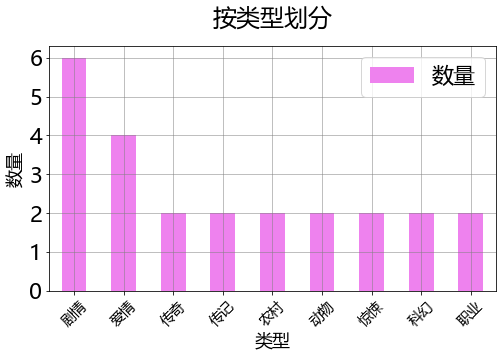

In [220]:
df_genre_sorted = df.groupby('修正类型')['电影名称'].count().rename(
    '数量').reset_index().sort_values('数量', ascending=False)
df_genre_sorted['数量'] = df_genre_sorted['数量'].astype('int')

plt.clf()
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['axes.facecolor'] = 'white'
ax = df_genre_sorted.plot(
    kind = 'bar',
    grid = True,
    fontsize = 22,
    rot = 0,
    color = ['violet'],
)
ax.set_title("按类型划分",fontsize= 24, pad=20)
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
ax.grid(color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel('类型',fontsize= 18)
ax.set_xticklabels(df_genre_sorted['修正类型'], fontsize= 14, rotation=45)
ax.set_yticklabels([0, 1, 2,3, 4, 5, 6, 7, 8])
ax.set_ylabel("数量",fontsize= 18)
ax.legend(fontsize=22)

fp_plot_genre = path_img + '/df_Releases_zgdypw_genre_{}.png'.format(str_pubdate_latest)
plt.savefig(fp_plot_genre, bbox_inches='tight')

plt.show()

##[7.3] P2 怀胎最久的影片是《荒野召唤1》，从备案到排期公映超过4.4年，名字从《荒野召唤之不忘初心》进化成了《荒野召唤1》。

In [222]:
df_view.columns

Index(['电影名称', 'pubtitle', 'pubdate', 'publink', '上映日期', '导演', '国别/地区',
       'img_remote', '主演', '备案名', '序号', '电影类别', '编码', '公映证号', '第一出品单位',
       '公示批次链接', '公示名称', '公示日期', '片名_cfReg', '编剧', '梗概', '备案公示日期', '备案单位',
       '是否修改', '备案立项号', '备案至今', '类型', '年代', '预测片名', 'kw', '主要角色', '修正类型',
       '距离公映许可'],
      dtype='object')

In [229]:
P2 = ''
P2 += '怀胎最久的影片是《{}》，'.format(df_view.iloc[0]['电影名称'])
P2 += '从备案到排期公映超过{}年，'.format(df_view.iloc[0]['备案至今'])
if df_view['距离公映许可'].fillna(0)[0] == 0:
         '已获取公映许可证，但尚未公示（通常一个月一次）。'
else:
  P2 += '从获取公映许可到排期上映超过{}个月，'.format(
      round(df_view['距离公映许可'].fillna(0)[0], 0))
if df_view.iloc[0]['备案名'] != '':
  P2 += '名字从《{}》进化成了《{}》'.format(df_view.iloc[0]['片名_cfReg'], df_view.iloc[0]['电影名称'])

record_longest = df_view[df_view['电影名称'] == df_view.iloc[0]['电影名称']]
if (not pd.isna(record_longest['第一出品单位']).iloc[0]) and \
               (record_longest['备案单位'].iloc[0] != record_longest['第一出品单位'].iloc[0]):
  P2 += '，第一出品方历经了{}'.format('、'.join(record_longest['原备案单位']))
  P2 += '最终由{}接手。'.format(df_view.iloc[0]['第一出品单位'])
P2 += '。'

print(P2)

怀胎最久的影片是《曾经相爱的我们》，从备案到排期公映超过9.4年，名字从《北京晚九朝五》进化成了《曾经相爱的我们》。


## [7.4] P3 同样坚守的还有...

In [230]:
ls_name_3plus_year = df_view.loc[df_view['备案至今']>3, '电影名称'].tolist()[1:]
ls_name_3plus_year = ['《'+ name + '》' for name in ls_name_3plus_year]
P3 = ""
P3 += '坚守了3年以上的影片还有{}。'.format('、'.join(ls_name_3plus_year))

print(P3)

坚守了3年以上的影片还有《半个⽉亮爬上来》、《不欺不遇》、《孤⼭魅影》、《恐婚：逃跑计划》。


## [7.5] P4 上市公司相关

In [233]:
df_view['第一出品单位'].unique()

array([nan, '浙江天映影视传媒有限公司', '杭州安迪文化传播有限公司', '长春长影影视传媒有限公司',
       '浙江东阳震之影视文化有限公司', '甘肃鼎级华彩影业有限公司', '山东电影制片厂有限公司'], dtype=object)

In [ ]:
# 本批次中与上市影视公司关联的项目有
info_public_film_co = pd.read_csv('/content/drive/MyDrive/Github/Article/reference/info_public_film_co.csv', index_col=0, encoding='utf-8-sig')
ls = info_public_film_co['公司简称'].apply(eval).sum()
pat_public = '|'.join(ls)
pat_public += '|阿里|腾讯|爱奇艺|英皇|寰亚|银都|美亚|大盛|儒意|灿星|横店|博纳|麦颂'
df_focus = df_view.loc[
    df_view['第一出品单位'].fillna('').str.contains(pat_public, regex=True)]

df_focus2 = df_view.loc[
    df_view['备案单位'].fillna('').str.contains(pat_public, regex=True)]

df_focus = pd.concat([df_focus, df_focus2], axis=0)
df_focus

In [237]:
idx_to_keep = [5]
df_focus_narrowed = df_focus[df_focus.index.isin(idx_to_keep)]

In [ ]:
df_focus_narrowed

In [239]:
P4 = ''
P4 += '国产片中，大数据分析识别出{}部上市影视公司关联项目'.format(df_focus.shape[0])
if df_focus.shape[0] > 0:
  P4 += '，占比{}%。'.format(round( (df_focus.shape[0]/(df_view.shape[0]-1)*100), 2 ) )
  P4 += '结合题材与出品方实力，ContenAI聚焦关注《{}》'.format(
      '》、《'.join(df_focus_narrowed['电影名称']))
  P4 += '，类型包括了{}'.format(
      '、'.join(df_focus_narrowed.修正类型.unique()))
#P4 += '，两部进口片质量都很不错，具有较大的竞争力。'

print(P4)

国产片中，大数据分析识别出1部上市影视公司关联项目，占比9.09%。结合题材与出品方实力，ContenAI聚焦关注《雄狮少年》，类型包括了剧情


## 热度 [WIP]

In [ ]:
# Update Maoyan Releases - Run only if necessary
path_maoyan = '/content/drive/MyDrive/Github/Content/sources/maoyan'
os.chdir(path_maoyan)

#%load_ext autoreload
%reload_ext autoreload
from maoyan import MAOYAN
maoyan = MAOYAN()

In [ ]:
df_view['电影名称'].to_numpy()

array(['乌海', '我是监护⼈', '世上只有妈妈好', '东江风云', '演员', '信者', '铁马英歌', '荒野召唤1',
       '⾎战狙击岭', '温暖的桥', '小镇故事多', '越界', '入殓师', '007：无暇赴死', '青春作伴好还乡'],
      dtype=object)

##[7.6] P5 按影片展示词云图

In [ ]:
df_label2img

In [241]:
%%capture
df_view['src_img'] = None
df_view['tgt_img'] = None

In [ ]:
genre_count = df_view.groupby('修正类型')['电影名称'].count(
    ).rename('类型数量').reset_index()
df_view = df_view.merge(genre_count, on='修正类型', how='left')
df_view = df_view.sort_values(['类型数量','上映日期'], ascending=[False, True])
df_view

In [243]:
P5 = ''
P5 = '\n看图识新片。'

print(P5)


看图识新片。


In [ ]:
df_view

《你最珍贵》
上映日期：2021-12-04
获得公映许可至今1.0个月，备案至今超过2.0年
编剧：张月
第一出品单位：山东电影制片厂有限公司
原备案单位：山东电影制片厂、永康三冠影业有限公司


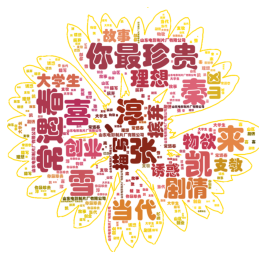

《不欺不遇》
上映日期：2021-12-17
获得公映许可至今7.0个月，备案至今超过4.3年
编剧：王庐璐
第一出品单位：浙江天映影视传媒有限公司


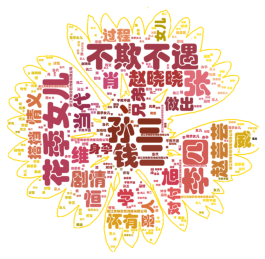

《雄狮少年》
上映日期：2021-12-17
获得公映许可至今nan个月，备案至今超过2.1年
原备案片名：《None》
编剧：李泽林
第一出品单位：nan


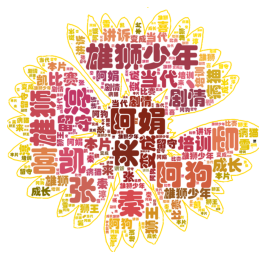

《曾经相爱的我们》
上映日期：2021-12-10
获得公映许可至今nan个月，备案至今超过9.4年
原备案片名：《None》
编剧：张立嘉（曾用名张立军）
第一出品单位：nan


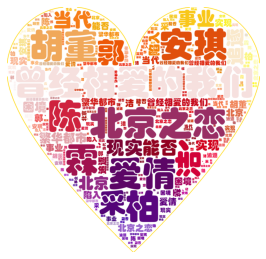

《恐婚：逃跑计划》
上映日期：2021-12-17
获得公映许可至今13.0个月，备案至今超过3.1年
编剧：刘涛（刘涛滔）
第一出品单位：长春长影影视传媒有限公司
原备案单位：森东润播文化传媒（北京）有限公司


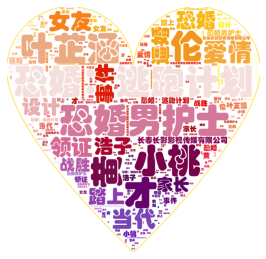

《半个⽉亮爬上来》
上映日期：2021-12-03
获得公映许可至今nan个月，备案至今超过7.7年
原备案片名：《None》
编剧：竹子
第一出品单位：nan


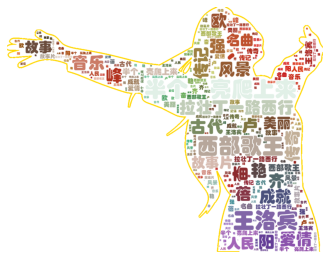

《我们是第⼀书记》
上映日期：2021-12-03
获得公映许可至今nan个月，备案至今超过0.3年
原备案片名：《None》
编剧：任杰、胡滨
第一出品单位：nan


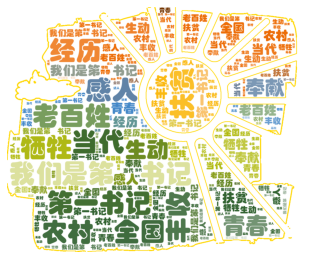

《笨鸟⼤冒险》
上映日期：2021-12-04
获得公映许可至今nan个月，备案至今超过2.6年
原备案片名：《None》
编剧：张琦
第一出品单位：nan


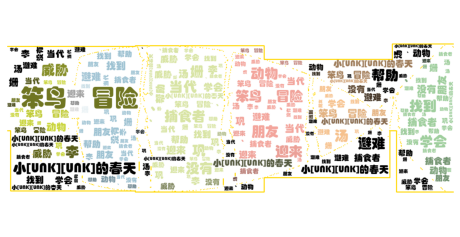

《高铁作证》
上映日期：2021-12-21
获得公映许可至今2.0个月，备案至今超过2.2年
编剧：孟广顺
第一出品单位：甘肃鼎级华彩影业有限公司
原备案单位：北京鼎级华彩文化传媒有限公司


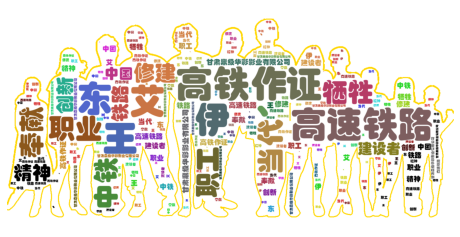

《孤⼭魅影》
上映日期：2021-12-24
获得公映许可至今7.0个月，备案至今超过3.3年
原备案片名：《孤山魅影》
编剧：黎海涛
第一出品单位：杭州安迪文化传播有限公司


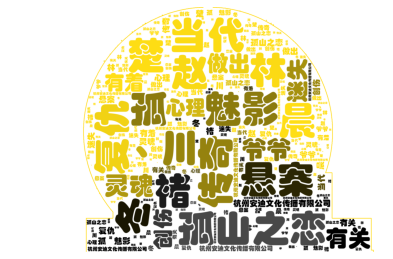

《魔法精灵》
上映日期：2022-01-01
获得公映许可至今nan个月，备案至今超过2.1年
原备案片名：《None》
编剧：夏晋
第一出品单位：nan


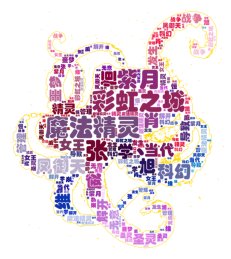

《屋内有⼈ 》
上映日期：2022-01-07
获得公映许可至今5.0个月，备案至今超过2.5年
原备案片名：《屋内有人》
编剧：边缘
第一出品单位：浙江东阳震之影视文化有限公司


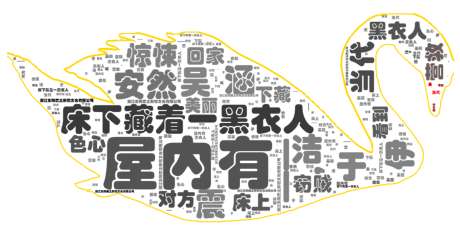

In [247]:
idx_actor = df_view['主演'].dropna().index

for i in df_view.drop_duplicates('电影名称').index:
  ls = [df_view.loc[i, '电影名称']] * 20
  ls += [df_view.loc[i, '预测片名']] *6
  ls += df_view.loc[i, '主要角色']*3
  if i in idx_actor:
    ls += df_view.loc[i, '主演']*3
  ls += [df_view.loc[i, '修正类型']] *3
  ls += [df_view.loc[i, '年代']]*2
  ls += df_view.loc[i, 'kw']

  if not pd.isna([df_view.loc[i, '第一出品单位']]):
    ls += [df_view.loc[i, '第一出品单位']]
  img_fn = df_view.loc[i, 'src_img']
  if not img_fn:
    img_fn = df_label2img.loc[
        df_label2img['label'] == df_view.loc[i, '修正类型'],
        'fn'
    ].iloc[0]
  txt = '《{}》'.format(df_view.loc[i, '电影名称'])
  txt += "\n上映日期：{}".format(str(df_view.loc[i, '上映日期']).split(' ')[0])
  txt += '\n获得公映许可至今{}个月'.format(df_view.loc[i, '距离公映许可'])
  txt += '，备案至今超过{}年'.format(df_view.loc[i, '备案至今'])

  if df_view.loc[i, '备案名'] != '':
    txt += '\n原备案片名：《{}》'.format(df_view.loc[i, '备案名'])

  txt += '\n编剧：{}'.format(df_view.loc[i, '编剧'])
  #txt += '\n类型：{}'.format(df_view.loc[i, '类型'])

  txt += '\n第一出品单位：{}'.format(df_view.loc[i, '第一出品单位'])
  if (not pd.isna(df_view.loc[i, '第一出品单位'])) and \
    (df_view.loc[i, '备案单位'] != df_view.loc[i, '第一出品单位']):
    txt +=  '\n原备案单位：{}'.format(df_view.loc[i, '备案单位'])
  
  print(txt)
  #txt += '{}\n'.format(df_view.loc[i, '梗概'])
  fp_img = path_img + '/genre_icon/{}'.format(img_fn)
  fp_mask = path_img + '/genre_icon/{}'.format('mask_' + img_fn)
  #fp_img = path_img + '/genre_icon/{}'.format('psychedelic-1084082_960_720.jpg')
  fp_generated_img = ut.generate_word_image(ls, 
                                               fp_img, 
                                               fp_mask,
                                               fp_prefix='ZGDYPW_Release_Preview',
                                               fp_suffix=str_pubdate_latest,
                                               img_width=400,
                                               )
  #display(Img(fp_generated_img, width=400))
  df_view.loc[i, 'tgt_img'] = fp_generated_img

In [251]:
P5 = ''
P5 = '看图了解新片。'

print(P5)

看图了解新片。


## [7.7] 指向电影官网

In [248]:
#####
E1 = '\n\n'
E1 += ''
E1 += 'ContentAI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。'
E1 += '备案与公映许可证信息来自中国国家电影局 China Film Administration, 官方网址\n'
E1 += 'http://www.chinafilm.gov.cn/chinafilm 。\n'
E1 += '公映许可证公示信息来自中国电影数据信息网 China Movie Database, 官方网址\n'
E1 += 'https://www.zgdypw.cn/ 。\n'
print(E1)



ContentAI结合自主调研及多方大数据比对，通过分析、建模，提炼关键信息。备案与公映许可证信息来自中国国家电影局 China Film Administration, 官方网址
http://www.chinafilm.gov.cn/chinafilm 。
公映许可证公示信息来自中国电影数据信息网 China Movie Database, 官方网址
https://www.zgdypw.cn/ 。



## [8.9] E2\E3, Pointer Text

In [249]:
E2 = '点击阅读原文查看本期ContentAI新片预览详表。'
E3 = '点击阅读原文查看本期ContentAI新片预览。'

## [7.8] S0 生成摘要

In [254]:
S0 = '近期预计上画新片{}部，'.format(df_rel_curr.shape[0])
S0 += '其中国产片{}部、进口片{}部，'.format(
    df_view[df_view['国别/地区'] == '中国'].shape[0],
    df_view[df_view['国别/地区'] != '中国'].shape[0])

n_domestic = df_view['备案立项号'].dropna().str.contains('影剧备字').shape[0]
n_domestic_story = df_view['备案立项号'].dropna().str.contains('影剧备字').sum()
if n_domestic - n_domestic_story > 0:
  S0 += '故事片{}部、'.format(n_domestic_story)
  n_domestic_documentary = \
    df_view['备案立项号'].dropna().str.contains('影纪备字').sum()
  if n_domestic_documentary > 0:
    S0 += '纪录片{}部。'.format(n_domestic_documentary)

S0 += '国产片中，改名的{}部，'.format(df_view.loc[df_view['备案名'] != '',:].shape[0])
S0 += '换主的{}部，'.format(df_view.loc[df_view['备案单位'] != '',:].shape[0])

S0 += '从获取公映许可到确定排期平均{}个月，'.format(
    round(df_view['距离公映许可'].fillna(0).mean(),1))
S0 += '从备案到排期平均超过{}年。'.format(df_view.iloc[0]['备案至今'])

S0 += 'ContentAI重点关注《{}》'.format(
    '》、《'.join(df_focus_narrowed['电影名称'])
)

#S0 += '、《乌海》。'

print(S0)

近期预计上画新片12部，其中国产片12部、进口片0部，故事片8部、纪录片1部。国产片中，改名的8部，换主的12部，从获取公映许可到确定排期平均2.9个月，从备案到排期平均超过2.0年。ContentAI重点关注《雄狮少年》


In [ ]:
df_view

# [5] Output Word Doc

## [5.1] Install Docx Lib

In [252]:
%%capture
!pip install python-docx
!pip install lxml
from docx import Document
from docx.shared import Inches
from docx.oxml.ns import qn
#from docx.text.parargaph import Paragraph

from docx.shared import Pt

## [5.2] Write Preview to docx and download

In [256]:
path_doc = '/content/drive/MyDrive/Github/Article/docx'
path_img = '/content/drive/MyDrive/Github/Article/img'

doc = Document()

# Set Document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Set Title
doc.core_properties.title = 'ZGDYPW_Release_Preview_' + str_pubdate_latest

doc.add_heading(T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

doc.add_paragraph(P1)
doc.add_picture(fp_plot_genre, width =Inches(6))
doc.add_paragraph(P2)
doc.add_paragraph(P3)
doc.add_paragraph(P4)

doc.add_paragraph(P5)
j = 1
for i in df_view.drop_duplicates('电影名称').index:

  txt = '《{}》'.format(df_view.loc[i, '电影名称'])
  txt += "\n上映日期：{}".format(str(df_view.loc[i, '上映日期']).split(' ')[0])
  if df_view.loc[i, '国别/地区'] == '中国':
    if pd.isna(df_view.loc[i, '距离公映许可']):
      txt += '\n已获得公映许可，尚未公示'
    else:
      txt += '\n获得公映许可至今{}个月'.format(df_view.loc[i, '距离公映许可'])
    txt += '，备案至今超过{}年'.format(df_view.loc[i, '备案至今'])

  if df_view.loc[i, '备案名'] != '' and (not pd.isna(df_view.loc[i, '备案名'])):
    txt += '\n原备案片名：《{}》'.format(df_view.loc[i, '备案名'])
  
  txt += '\n导演：{}'.format(df_view.loc[i, '导演'])
  if not pd.isna(df_view.loc[i, '编剧']):
    txt += '\n编剧：{}'.format(df_view.loc[i, '编剧'])
  txt += '\n主演：{}'.format(df_view.loc[i, '主演']) 


  if len(df_view.loc[i, '主要角色']) > 0:
    txt += '\n主要角色：{}'.format('、'.join(df_view.loc[i, '主要角色']))
  txt += '\n类型：{}'.format(df_view.loc[i, '修正类型'])
  txt += '\n国别/地区：{}'.format(df_view.loc[i, '国别/地区'])

  if not pd.isna(df_view.loc[i, '第一出品单位']):
    txt += '\n第一出品单位：{}'.format(df_view.loc[i, '第一出品单位'])
  if (not pd.isna(df_view.loc[i, '第一出品单位'])) and \
    (df_view.loc[i, '备案单位'] != df_view.loc[i, '第一出品单位']):
    txt +=  '\n原备案单位：{}'.format(df_view.loc[i, '备案单位'])

  doc.add_paragraph("[{}]_____________".format(j))
  j += 1
  fp_poster = path_zgdypw+ '/img/' + df_view.loc[i, 'img_remote'].split('/')[-1]
  doc.add_picture(fp_poster, width =Inches(4))
  fp_img = df_view.loc[i, 'tgt_img']
  doc.add_paragraph(txt)
  doc.add_picture(fp_img, width =Inches(4))
  doc.add_paragraph('\n')

doc.add_paragraph(E1)
doc.add_paragraph(E2)

doc.save(path_doc + '/ZGDYPW_Release_Preview_' + str_pubdate_latest +'.docx')

In [257]:
# Download Document
from google.colab import files

files.download(
    path_doc + '/ZGDYPW_Release_Preview_' + str_pubdate_latest +'.docx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
HTML(df_view[['梗概']].to_html())

## [5.3] Write Table to docx and download

In [261]:
path_doc = '/content/drive/MyDrive/Github/Article/docx'

doc = Document()

# Set Document Font 
doc.styles['Normal'].font.name = '微软雅黑'
r = doc.styles['Normal']._element
r.rPr.rFonts.set(qn('w:eastAsia'), '微软雅黑')

# Set Title
doc.core_properties.title = 'ZGDYPW_Release_s_Table_' + str_pubdate_latest

doc.add_heading('详表：' + T1, 0)

p = doc.add_paragraph(S0, style='Intense Quote')

table = doc.add_table(rows=1, cols=1, style='Light List Accent 4')
j = 1
for i, row in df_view.iterrows():
  row_cells = table.add_row().cells
  row_cells[0].text = '[{}] 《{}》'.format(j ,row['电影名称'])
  j += 1

  # 上映日期
  row_cells = table.add_row().cells
  row_cells[0].text = '上映日期：{}'.format(str(row['上映日期']).split(' ')[0]) 

  # 许可至今，备案至今
  if row['国别/地区'] == '中国':
    row_cells = table.add_row().cells
    if pd.isna(row['距离公映许可']):
      row_cells[0].text = '已获得公映许可，尚未公示'
    else:
      row_cells[0].text = '获得公映许可至今{}个月'.format(row['距离公映许可'])
      row_cells[0].text += '，备案至今超过{}年'.format(row['备案至今'])

  # 改名
  if row['备案名'] != '' and (not pd.isna(row['备案名'])):
    row_cells = table.add_row().cells
    row_cells[0].text = '原备案名：《{}》'.format(row['备案名'])

  # 导演
  if row['导演'] != '' and (not pd.isna(row['导演'])):
    row_cells = table.add_row().cells
    row_cells[0].text = '导演：{}'.format(row['导演'])
  
  # 编剧
  if not pd.isna(row['编剧']):
    row_cells = table.add_row().cells
    row_cells[0].text = '编剧: ' + row['编剧'] 

  # 主演
  if not pd.isna(row['主演']):
    row_cells = table.add_row().cells
    row_cells[0].text = '主演: ' + row['主演'] 

  # 主要角色
  if len(row['主要角色']) > 0:
    row_cells = table.add_row().cells
    row_cells[0].text = '主要角色：{}'.format('、'.join(row['主要角色']))

  # 类型
  if not pd.isna(row['修正类型']):
    row_cells = table.add_row().cells
    row_cells[0].text = '类型: ' + row['修正类型']

  # 国别/地区
  if not pd.isna(row['国别/地区']):
    row_cells = table.add_row().cells
    row_cells[0].text = '国别/地区: ' + row['国别/地区']

  # 出品方变更
  if not pd.isna(row['第一出品单位']):
    row_cells = table.add_row().cells
    row_cells[0].text ='第一出品单位：{}'.format(row['第一出品单位'])
  if (not pd.isna(row['第一出品单位'])) and \
     (row['第一出品单位'] != row['备案单位']):
    row_cells = table.add_row().cells
    row_cells[0].text =  '备案单位：{}'.format(row['备案单位'])

  #梗概
  row_cells = table.add_row().cells
  row_cells[0].text = row['梗概'].lstrip('\w+')

  row_cells = table.add_row().cells
  row_cells[0].text = ''

doc.add_paragraph(E1)
doc.add_paragraph(E3)

doc.save('/ZGDYPW_Release_Table_' + str_pubdate_latest +'.docx')

In [260]:
files.download('/ZGDYPW_Release_Table_' + str_pubdate_latest +'.docx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>